# Identifying Entities in Healthcare Data


In [ ]:
!pip install pycrf
!pip install sklearn-crfsuite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pycrf: filename=pycrf-0.0.1-py3-none-any.whl size=1897 sha256=ded797aa0702c028161673aab8eae5f95fb6dd16525f7e7f86e72168128ae0bc
  Stored in directory: /root/.cache/pip/wheels/da/5c/29/bf862cc934550145485b0e0502cb8deadffb387f6a096e4b5f
Successfully built pycrf
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.8 MB/s eta 0:00:00


In [7]:
import pathlib
import os
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [8]:
base_dir = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/NLP/CRF_Medical_Data')
os.chdir(str(base_dir))

In [9]:
# Importing libraries

import spacy
import textwrap
import warnings
import json
import sklearn_crfsuite

import pandas as pd

from tqdm import tqdm
from sklearn_crfsuite import metrics

warnings.filterwarnings("ignore")
model = spacy.load("en_core_web_sm")

##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**

### Construct the proper sentences from individual words and print the 5 sentences.

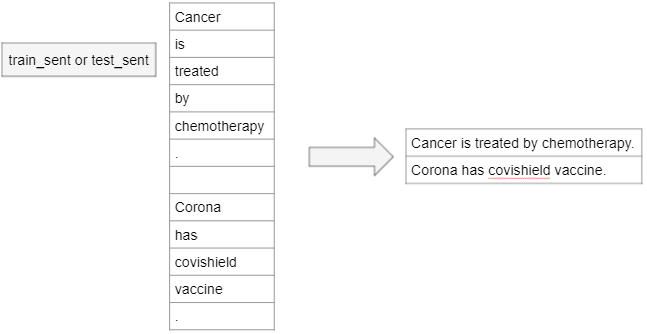




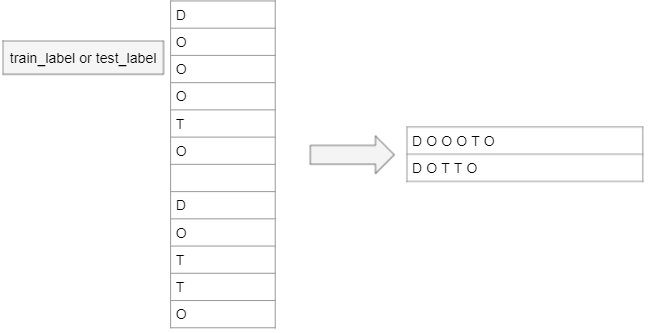

In [10]:
# Function to read the file if given filename

def read_file(file_name):
    with open(file_name, 'r', encoding='utf-8') as file:
        content = file.readlines()
    
    sentences = []
    sentence = ""
    word_count = 0
    
    for word in content:
        word = word.strip('\n')
        if word == "":
            sentences.append(sentence.rstrip(" "))
            sentence = ""
        else:
            word_count += 1
            sentence += word + " "
            
    print("Items in File       : ", len(content))
    print("Number of Words     : ", word_count)
    print("Number of Sentences : ", len(sentences))
    
    prefix = "First Sentence      :  "
    wrapper = textwrap.TextWrapper(initial_indent = prefix, width = 150, subsequent_indent = ' '*len(prefix))
    print(wrapper.fill(sentences[0]))
    
    return sentences

In [11]:
# Reading the train and test sentences and labels
with open('train_sent', 'r') as train_sent_file:
  train_words = train_sent_file.readlines()

with open('train_label', 'r') as train_labels_file:
  train_labels_by_word = train_labels_file.readlines()

with open('test_sent', 'r') as test_sent_file:
  test_words = test_sent_file.readlines()

with open('test_label', 'r') as test_labels_file:
  test_labels_by_word = test_labels_file.readlines()

In [12]:
# Sanity check to see that the number of tokens and no. of corresponding labels match.
print("Count of tokens in training set\n","No. of words: ",len(train_words),"\nNo. of labels: ",len(train_labels_by_word))
print("\n\nCount of tokens in test set\n","No. of words: ",len(test_words),"\nNo. of labels: ",len(test_labels_by_word))

Count of tokens in training set
 No. of words:  48501 
No. of labels:  48501


Count of tokens in test set
 No. of words:  19674 
No. of labels:  19674


In [13]:
# Function to combine tokens belonging to the same sentence. Sentences are separated by "\n" in the dataset.
def convert_to_sentences(dataset):
    sent_list = []
    sent = ""
    for entity in dataset:
        if entity != '\n':
            sent = sent + entity[:-1] + " "       # Adding word/label to current sentence / sequence of labels 
        else: 
            sent_list.append(sent[:-1])           # Getting rid of the space added after the last entity.
            sent = ""
    return sent_list

In [14]:
# Converting tokens to sentences and individual labels to sequences of corresponding labels.
train_sentences = convert_to_sentences(train_words)
train_labels = convert_to_sentences(train_labels_by_word)
test_sentences = convert_to_sentences(test_words)
test_labels = convert_to_sentences(test_labels_by_word)

In [15]:
print("First five training sentences and their labels:\n")
for i in range(5):
    print(train_sentences[i],"\n",train_labels[i],"\n")

First five training sentences and their labels:

All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status ) 
 O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 ) 
 O O O O O O O O O O O O O O O O O O O O O O O O O 

Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 ) 
 O O O O O O O O O O O O O O O 

The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 ) 
 O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 

Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 a

In [16]:
print("First five test sentences and their labels:\n")
for i in range(5):
    print(test_sentences[i],"\n",test_labels[i],"\n")

First five test sentences and their labels:

Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 ) 
 O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 

As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration 
 O O O O O O O O O O O O O O O O O O O 

The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period 
 O O O O O O O O O O O O O O O O O O O O O O O O 

There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 ) 
 O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 

Fluctuations in ambient temperature are inversely correlated to ch

### Count the number of sentences in the processed train and test dataset 

In [17]:
print("Number of sentences in the train dataset: {}".format(len(train_sentences)))
print("Number of sentences in the test dataset: {}".format(len(test_sentences)))

Number of sentences in the train dataset: 2599
Number of sentences in the test dataset: 1056


### Count the number of lines of labels in the processed train and test dataset.

In [18]:
print("Number of lines of labels in the train dataset: {}".format(len(train_labels)))
print("Number of lines of labels in the test dataset: {}".format(len(test_labels)))

Number of lines of labels in the train dataset: 2599
Number of lines of labels in the test dataset: 1056


##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 

### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [20]:
def get_pos_tags(reviews, labels, tag = ""):
    
    sentence = []
    pos = []
    lemma = []
    text = []
    label = []
    
    i = 1 # Sentence Count
    
    for review, review_labels in tqdm(zip(reviews, labels)):
        #doc = model(review)
        for doc, review_label in zip(review.split(), review_labels.split()):
            s = model(doc)
            for tok in s:
                sentence.append(tag + str(i))
                pos.append(tok.pos_)
                lemma.append(tok.lemma_)
                text.append(tok.text)
                label.append(review_label)
        
        i += 1
    
    return sentence, pos, lemma, text, label

print("Training Sentences")
print("------------------")
train_sentence, train_pos, train_lemma, train_text, train_label = get_pos_tags(train_sentences, train_labels, "train_")
train_frequency_df = pd.DataFrame({'sentence':train_sentence, 'text':train_text,'lemma':train_lemma,'pos':train_pos,'label':train_label})

print("\n")
print("Testing Sentences")
print("------------------")
test_sentence, test_pos, test_lemma, test_text, test_label = get_pos_tags(test_sentences, test_labels, "test_")
test_frequency_df = pd.DataFrame({'sentence':test_sentence, 'text':test_text,'lemma':test_lemma,'pos':test_pos,'label':test_label})

# Convert the data into a dataframe object.
frequency_df = pd.concat((train_frequency_df.copy(), test_frequency_df.copy()),axis=0)

Training Sentences
------------------


2599it [06:00,  7.21it/s]




Testing Sentences
------------------


1056it [02:18,  7.63it/s]


### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [21]:
# Get most frequent text forms of nouns

frequency_df[(frequency_df['pos'] == 'NOUN') | (frequency_df['pos'] == 'PROPN')]['text'].value_counts()[:25]

patients        492
treatment       281
cancer          200
therapy         175
disease         143
cell            140
lung            116
group            94
gene             88
chemotherapy     88
effects          85
results          79
women            77
patient          75
TO_SEE           75
surgery          71
risk             71
cases            71
analysis         70
human            67
rate             67
response         66
survival         65
children         64
effect           64
Name: text, dtype: int64

In [22]:
# Get most frequent lemma forms of nouns

frequency_df[(frequency_df['pos'] == 'NOUN') | (frequency_df['pos'] == 'PROPN')]['lemma'].value_counts()[:25]

patient         587
treatment       316
cancer          226
cell            203
therapy         182
disease         172
effect          163
case            132
group           128
lung            120
result          118
gene            112
year            105
rate            102
trial            91
chemotherapy     91
woman            89
analysis         86
protein          82
response         81
risk             78
child            78
human            77
TO_SEE           75
mutation         75
Name: lemma, dtype: int64

## Defining features for CRF

We have defined the following features for CRF modeule building:


*  f1 = input word is in lower case;
*  f2 = last 3 characters of word;
*  f3 = last 2 characters of word;

*   f4 = 1; if the word is in uppercase; otherwise, 0

*  f5 = 1; if the word is a number; otherwise, 0
*   f6 = 1; if the word starts with a capital letter; otherwise, 0



*  f7 = 1; if PoS Tag of the word is Noun or Pronoun; otherwise, 0
*  f8 = 1; if PoS Tag of the word is Noun or Pronoun; otherwise, 0


*  f9 = B; if beginning
*  f10 = E; if ending










In [23]:
# Let's define the features to get the feature value for one word.

def getFeaturesForOneWord(word_details, pos):
    word_details.reset_index(drop=True, inplace=True)
    word = word_details[pos][0]
    postag = word_details[pos][1]
    
    features = [
        'bias=' + "1.0",
        'word.lower=' + word.lower(),
        'word[-3]=' + word[:-3],
        'word[-2]=' + word[:-2],
        'word.islower=%s' % word.islower(),
        'word.isupper=%s' % word.isupper(),
        'word.istitle=%s' % word.istitle(),
        'word.isdigit=%s' % word.isdigit(),
        'postag=' + postag,
        'postag.isnounpronoun=%s' % (postag in ['NOUN','PROPN']),
    ]
    
    if (pos > 0):
        prev_word = word_details[pos-1][0]
        prev_postag = word_details[pos-1][1]
        
        features.extend([
            'prev_word.lower=' + prev_word.lower(),
            'prev_word[-3]=' + prev_word[:-3],
            'prev_word[-2]=' + prev_word[:-2],
            'prev_word.islower=%s' % prev_word.islower(),
            'prev_word.isupper=%s' % prev_word.isupper(),
            'prev_word.istitle=%s' % prev_word.istitle(),
            'prev_word.isdigit=%s' % prev_word.isdigit(),
            'prev_postag=' + prev_postag,
            'prev_postag.isnounpronoun=%s' % (prev_postag in ['NOUN','PROPN']),
        ])
    else:
        features.append('BEG')
        
    if (pos < len(word_details) - 1):
        next_word = word_details[pos+1][0]
        next_postag = word_details[pos+1][1]
        
        features.extend([
            'next_word.lower=' + next_word.lower(),
            'next_word[-3]=' + next_word[:-3],
            'next_word[-2]=' + next_word[:-2],
            'next_word.islower=%s' % next_word.islower(),
            'next_word.isupper=%s' % next_word.isupper(),
            'next_word.istitle=%s' % next_word.istitle(),
            'next_word.isdigit=%s' % next_word.isdigit(),
            'next_postag=' + next_postag,
            'next_postag.isnounpronoun=%s' % (next_postag in ['NOUN','PROPN']),
        ])
    else:
        features.append('END')
        
    return features

# Getting the features
## Write a code/function to get the features for a sentence

In [24]:
# Write a code to get features for a sentence.

def get_word_details(item):
    return item["text"], item["pos"]

def getFeaturesForOneSentence(sentence_id):
    words_for_features = frequency_df[frequency_df["sentence"] == sentence_id].apply(get_word_details, axis=1)
    return [getFeaturesForOneWord(words_for_features, pos) for pos in range(len(words_for_features))]

In [25]:
features = getFeaturesForOneSentence("train_1")
prefix = "01 Sentence : "
wrapper = textwrap.TextWrapper(initial_indent = prefix, width = 150, subsequent_indent = ' '*len(prefix))
print(wrapper.fill(train_sentences[0]))
print('\n')

i = 1
for feature in features:
    prefix = str('%02d' % i) + " Word     : "
    wrapper = textwrap.TextWrapper(initial_indent = prefix, width = 150, subsequent_indent = ' '*len(prefix))
    print(wrapper.fill(str(feature)))
    i += 1

01 Sentence : All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route ,
              indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )


01 Word     : ['bias=1.0', 'word.lower=all', 'word[-3]=', 'word[-2]=A', 'word.islower=False', 'word.isupper=False', 'word.istitle=True',
              'word.isdigit=False', 'postag=PRON', 'postag.isnounpronoun=False', 'BEG', 'next_word.lower=live', 'next_word[-3]=l', 'next_word[-2]=li',
              'next_word.islower=True', 'next_word.isupper=False', 'next_word.istitle=False', 'next_word.isdigit=False', 'next_postag=VERB',
              'next_postag.isnounpronoun=False']
02 Word     : ['bias=1.0', 'word.lower=live', 'word[-3]=l', 'word[-2]=li', 'word.islower=True', 'word.isupper=False', 'word.istitle=False',
              'word.isdigit=False', 'postag=VERB', 'postag.isnounpronoun=False', 'prev_word.lower=all', 'prev_word[-3]='

Write a code/function to get the labels of a sentence

In [26]:
# Write a code to get the labels for a sentence.

def getLabelsForOneSentence(sentence_id):
    return frequency_df[frequency_df["sentence"] == sentence_id]["label"]

In [27]:
labels = getLabelsForOneSentence("train_1")

prefix = "01 Labels  : "
wrapper = textwrap.TextWrapper(initial_indent = prefix, width = 150, subsequent_indent = ' '*len(prefix))
print(wrapper.fill(" ".join(labels)))

01 Labels  : O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O


# Define input and target variables

Correctly computing X and Y sequence matrices for training and test data. Check that both sentences and labels are processed

## Define the features' values for each sentence as input variable for CRF model in test and the train dataset

In [28]:
print("Training Sentences")
print("------------------")
X_train = [getFeaturesForOneSentence("train_" + str(i+1)) for i in tqdm(range(len(train_sentences)))] 

print("\n")
print("Testing Sentences")
print("------------------")
X_test = [getFeaturesForOneSentence("test_" + str(i+1)) for i in tqdm(range(len(test_sentences)))] 

Training Sentences
------------------


100%|██████████| 2599/2599 [00:38<00:00, 67.52it/s]




Testing Sentences
------------------


100%|██████████| 1056/1056 [00:14<00:00, 71.01it/s]


In [29]:
print("Training Labels")
print("------------------")
Y_train = [getLabelsForOneSentence("train_" + str(i+1)) for i in tqdm(range(len(train_labels)))] 

print("\n")
print("Testing Labels")
print("------------------")
Y_test = [getLabelsForOneSentence("test_" + str(i+1)) for i in tqdm(range(len(test_labels)))]

Training Labels
------------------


100%|██████████| 2599/2599 [00:30<00:00, 84.71it/s]




Testing Labels
------------------


100%|██████████| 1056/1056 [00:11<00:00, 92.93it/s]


### Build the CRF Model

In [32]:
# Build the CRF model.

crf = sklearn_crfsuite.CRF(c1=0.1, c2=0.1, max_iterations=100, all_possible_transitions=True)
try:
  crf.fit(X_train, Y_train) 
except AttributeError:
    pass

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [31]:
Y_pred = crf.predict(X_test)

Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [33]:
f1_score = metrics.flat_f1_score(Y_test, Y_pred, average='weighted')
print('Predicted F1-Score : {0} % '.format(round(f1_score*100,2)))

Predicted F1-Score : 92.07 % 


## Identifying Diseases and Treatments using Custom NER
We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.

Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

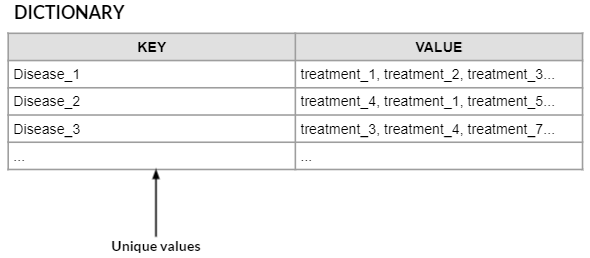

In [34]:
def get_labels_as_array(labels):
    pred_label = []

    for label in labels:
        pred_label.extend(label)
        
    return pred_label

test_frequency_df["pred_label"] = get_labels_as_array(Y_pred)
test_frequency_df.head(5)

,sentence,text,lemma,pos,label,pred_label
0,test_1,Furthermore,furthermore,ADV,O,O
1,test_1,",",",",PUNCT,O,O
2,test_1,when,when,SCONJ,O,O
3,test_1,all,all,PRON,O,O
4,test_1,deliveries,delivery,NOUN,O,O


In [35]:
new_df = test_frequency_df[(test_frequency_df.pred_label != 'O')]
new_df.set_index('sentence',inplace=True)

disease=[]
treatment=[]
sentence=[]
med_dict = {}

for i in new_df.index.unique():
    try:
        val = new_df.loc[i,'pred_label'].unique()
        if len(val) == 2:
            disease_val = new_df[new_df.pred_label == 'D'].loc[i,'text']
            treatment_val = new_df[new_df.pred_label == 'T'].loc[i,'text']
            disease_single = disease_val if type(disease_val) == str else " ".join(disease_val)
            treatment_single = treatment_val if type(treatment_val) == str else " ".join(treatment_val)
            if disease_single not in disease:
                med_dict[disease_single] = treatment_single
            else:
                print('Entered')
                med_dict[disease_single] = med_dict.get(disease_single)+'/'+treatment_single
    except AttributeError:
        pass

print(json.dumps(dict(sorted(med_dict.items())), indent = 4))

{
    "AOM drug - resistant S. pneumoniae": "Amoxicillin remains the antibiotic of choice",
    "Barrett 's esophagus": "Acid suppression therapy",
    "Cranial nerve injuries": "persistent conduction blocks",
    "Eisenmenger 's syndrome": "laparoscopic cholecystectomy",
    "Parkinson 's disease": "Microelectrode - guided posteroventral pallidotomy",
    "Pneumocystis carinii pneumonia": "trimethoprim - sulfamethoxazole",
    "Spontaneous splenic rupture": "granulocyte colony - stimulating factor ( G - CSF )",
    "abdominal pain": "thoracic paravertebral block ( tpvb )",
    "acute carbon monoxide poisoning": "Hyperbaric or normobaric oxygen",
    "acute cerebral ischemia": "Antiplatelet therapy",
    "acute migraine treatment": "Sumatriptan",
    "acute myocardial infarction": "thrombolytic treatment",
    "acute occlusion of the middle cerebral artery a large embolus or high - grade stenosis": "thrombolytic therapy",
    "advanced non -- small - cell lung cancer": "paclitaxel plus

In [36]:
disease=''
treatment=''

input_text = []
input_pos = []
input_label = []

input_sent = 'hereditary retinoblastoma'

input_model = model(input_sent)

for word in input_model:
    input_text.append(word.text)
    input_pos.append(word.pos_)
    input_label.append('D')

details_sent = pd.DataFrame({'text':input_text, 'pos':input_pos,'label':input_label})
words_for_features = details_sent.apply(get_word_details, axis=1)

test_sent = []

for i in range(len(input_sent.split())):
    test_sent.append(getFeaturesForOneWord(words_for_features, i))

for i,tag in enumerate(crf.predict([test_sent])[0]):
    
    if tag == 'D':
        tr = input_sent.split()[i]
        disease += tr + " "

        if tr in med_dict:
            treatment += med_dict.get(tr) + ", "
            
        if disease.strip() in med_dict:
            treatment += med_dict.get(disease.strip()) + ", "

disease = disease.strip()

if len(treatment) == 0:
    treatment = 'Not Available'
else:
    treatment = treatment.rstrip(", ")
    
print('Identified Disease   :', disease)
print('Identified Treatment :', treatment)

Identified Disease   : retinoblastoma
Identified Treatment : radiotherapy, radiotherapy
